## Wikisum-ptbr dataset characterization

### 1. Read documents and summaries

In [1]:
path_web = '../../data/brwac_ref_urls_sentences_mongodb_v2/'
path_wiki = '../../data/wikipedia_articles_json/'
file_names = ['AA/processed_wiki_{:02d}.json'.format(i) for i in range(57)] + ['AA/processed_wiki_{:02d}.json'.format(i) for i in range(61,67)] + ['AA/processed_wiki_75.json']

In [2]:
import json
from nltk import word_tokenize

n_documents_per_example = []
n_words_per_input = []
n_words_per_output = []
n_examples_per_n_documents = [0 for i in range(16)]
i = 0
for file_name in file_names:
    print('{}/{}'.format(i, len(file_names)))
    with open(path_web + file_name, 'r') as input_file:
        with open(path_wiki + file_name, 'r') as output_file:
            for input_line in input_file:
                output_line = output_file.readline()
                input_content = json.loads(input_line)
                output_content = json.loads(output_line)
                urls = input_content['brwac_urls']
                n_documents = len(urls)
                n_documents_per_example.append(n_documents)
                n_words = 0
                #print('Artigo {}'.format(input_content['wiki_title']))
                for url in urls:
                    n_words = n_words + len(urls[url].split(' '))
                    #print(url)
                n_words_per_input.append(n_words)
                wiki_lead = output_content['text'][0]
                n_words_per_output.append(len(wiki_lead.split(' ')))
                n_examples_per_n_documents[n_documents] = n_examples_per_n_documents[n_documents] + 1
    i = i + 1



0/64
1/64
2/64
3/64
4/64
5/64
6/64
7/64
8/64
9/64
10/64
11/64
12/64
13/64
14/64
15/64
16/64
17/64
18/64
19/64
20/64
21/64
22/64
23/64
24/64
25/64
26/64
27/64
28/64
29/64
30/64
31/64
32/64
33/64
34/64
35/64
36/64
37/64
38/64
39/64
40/64
41/64
42/64
43/64
44/64
45/64
46/64
47/64
48/64
49/64
50/64
51/64
52/64
53/64
54/64
55/64
56/64
57/64
58/64
59/64
60/64
61/64
62/64
63/64


In [3]:
print(n_examples_per_n_documents)
n_examples = 0
for qtd in n_examples_per_n_documents[1:]:
    n_examples = n_examples + qtd
print(n_examples)

[93017, 6456, 17781, 2117, 10194, 1138, 7409, 810, 5693, 592, 4530, 489, 3723, 413, 1819, 79710]
142874


In [4]:
# filter dataset (n_words for input and output)
filtered_indexes = [i for i in range(len(n_words_per_output)) if n_words_per_input[i] > 1000 and n_words_per_output[i] > 20]
filtered_n_words_per_input = [n_words_per_input[i] for i in range(len(n_words_per_output)) if n_words_per_input[i] > 1000 and n_words_per_output[i] > 20]
filtered_n_words_per_output = [n_words_per_output[i] for i in range(len(n_words_per_output)) if n_words_per_input[i] > 1000 and n_words_per_output[i] > 20]
filtered_n_documents_per_example = [n_documents_per_example[i] for i in range(len(n_documents_per_example)) if n_words_per_input[i] > 1000 and n_words_per_output[i] > 20]


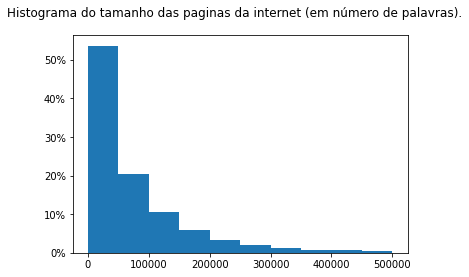

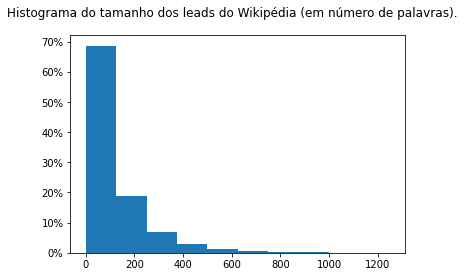

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

plt.hist(filtered_n_words_per_input, weights=np.ones(len(filtered_n_words_per_input)) / len(filtered_n_words_per_input), range=(0, 500000))
plt.suptitle('Histograma do tamanho das paginas da internet (em número de palavras).')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

plt.hist(filtered_n_words_per_output,weights=np.ones(len(filtered_n_words_per_output)) / len(filtered_n_words_per_output), range=(0, 1250))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.suptitle('Histograma do tamanho dos leads do Wikipédia (em número de palavras).')
plt.show()


In [6]:
# percentile analysis
step = int(len(filtered_n_words_per_input)/9)
percentiles = ['{}%'.format(i) for i in range(10, 101, 10)]
filtered_n_words_per_input.sort()
filtered_n_words_per_output.sort()
filtered_n_documents_per_example.sort()
n_words_per_input_percentiles = [filtered_n_words_per_input[i] for i in range(0, len(filtered_n_words_per_input)-1, step)]
n_words_per_output_percentiles = [filtered_n_words_per_output[i] for i in range(0, len(filtered_n_words_per_output)-1, step)]
n_documents_per_example_percentiles = [filtered_n_documents_per_example[i] for i in range(0, len(filtered_n_documents_per_example)-1, step)]

print(percentiles) 
print(n_words_per_input_percentiles)
print(n_words_per_output_percentiles)
print(n_documents_per_example_percentiles)
print(len(filtered_n_words_per_input))

['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[1001, 8033, 15059, 24210, 36340, 53424, 77475, 114777, 183980, 1268802]
[21, 30, 40, 49, 64, 86, 117, 168, 266, 3846]
[1, 2, 4, 8, 15, 15, 15, 15, 15, 15]
119483


In [11]:
from codecs import open
import re

# generate filtered dataset, remove clones from input
def detect_clone(text, article_sections):
    text_tokens = text.split(' ')
    for section in article_sections:
        section_tokens = section.split(' ')
        if(len(section_tokens) > 0):
            #print(list(section_unigrams))
            count_intersection = len(set(section_tokens) & set(text_tokens))
            clone_prob = float(count_intersection)/len(section_tokens)
            #print(count_intersection, len(section_tokens), len(text_tokens), clone_prob)
            #print(clone_prob)
            if(clone_prob > 0.5):
                #print(section, text)
                return True
    return False

def split_sentences(docs, max_len):
    to_out_docs = []
    for doc in docs:
        tokens = doc.split(' ')
        if len(tokens) > max_len:
            i = 0
            sub_doc = ''
            n_tokens = 0
            for sentence in doc.split('.'):
                n_tokens = n_tokens + len(word_tokenize(sentence))
                if(n_tokens > max_len):
                    break
                sub_doc = sub_doc + sentence
            to_out_docs.append(sub_doc)
        elif (len(tokens) > 5): # at least 5 tokens in 1 sentence
            to_out_docs.append(doc)
    return to_out_docs

def preprocess_text(p):
    p = re.sub(r"([?.!,¿])", r" \1 ", p)
    p = re.sub(r'[" "]+', " ", p)
    # substituir tudo por espaço exceto (a-z, A-Z, ".", "?", "!", ",", letras com acentos da lingua pt)
    p = re.sub(r"[^a-zA-ZçÇèéêíáâãõôóúûÉÊÍÁÂÃÕÔÓÚÛöüäëï0-9.?!:,()]+", " ", p).lower()
    return p


0/64
1/64
2/64
3/64
4/64
5/64
6/64
7/64
8/64
9/64
10/64
11/64
12/64
13/64
14/64
15/64
16/64
17/64
18/64
19/64
20/64
21/64
22/64
23/64
24/64
25/64
26/64
27/64
28/64
29/64
30/64
31/64
32/64
33/64
34/64
35/64
36/64
37/64
38/64
39/64
40/64
41/64
42/64
43/64
44/64
45/64
46/64
47/64
48/64
49/64
50/64
51/64
52/64
53/64
54/64
55/64
56/64
57/64
58/64
59/64
60/64
61/64
62/64
63/64


IndexError: list index out of range

In [ ]:

i = 0
j = 0
k = 0
with open('../../data/wikisum_ptbr/input_with_punc.csv', 'wb') as dataset_input_file:
    with open('../../data/wikisum_ptbr/output_with_punc.csv', 'wb') as dataset_output_file:
        with open('../../data/wikisum_ptbr/docids_with_punc.json', 'wb') as dataset_docids_file:
            for file_name in file_names:
                print('{}/{}'.format(k, len(file_names)))
                with open(path_web + file_name, 'rb') as input_file:
                    with open(path_wiki + file_name, 'rb') as output_file:
                        for input_line in input_file:
                            output_line = output_file.readline()
                            if(i == filtered_indexes[j]):
                                input_content = json.loads(input_line)
                                output_content = json.loads(output_line)
                                full_input = input_content['wiki_title'].lower() + " </s> "
                                full_input_size = 0
                                docids = []
                                wiki_text = preprocess_text(output_content['text'][0].replace('\n', '')) + '\n'
                                #print('oi')
                                #print(wiki_text)
                                for url in input_content['brwac_urls']:
                                    if(detect_clone(input_content['brwac_urls'][url], [wiki_text]) == False):
                                        docids.append(url)
                                        for sentence in split_sentences(input_content['brwac_urls'][url].split('\n'), 100):
                                            full_input = full_input + sentence + ' <\s> '
                                            full_input_size = full_input_size + len(sentence.split(' '))
                                full_input = full_input + '\n'
                                if(full_input_size >= 1000):
                                    dataset_input_file.write(full_input.encode('utf-8'))
                                    dataset_output_file.write(wiki_text.encode('utf-8'))
                                    docids_dict = {'wiki_id' : output_content['id'], 'wiki_title' : output_content['title'], 'docids' : docids}
                                    dataset_docids_file.write('{}\n'.format(json.dumps(docids_dict, ensure_ascii=False)).encode('utf-8'))
                                j = j + 1
                            i = i + 1
                k = k + 1